# 物体検出を試す(SSD)

## 0. やりたいこと

物体認識を試してみる。

今回試すのはSSD。<br>
このモデルは「Single Shot MultiBox Detector（SSD）」という<br>
畳み込みニューラルネットワーク(CNN:Convolutional Neural Network)を用いた<br>
物体検出アルゴリズムです。<br>
今回はKerasで試します。

SSD(Single Shot Multibox Detector)による物体検出<br>
https://www.youtube.com/watch?v=f4ApPUt-y94

## 1. 利用する実装

ssd_keras<br>
上記のモデルをKerasで実装したものが公開されています。

rykov8/ssd_keras<br>
https://github.com/rykov8/ssd_keras

こちらのレポジトリ、学習済みモデルがダウンロードすることが出来るので長い学習時間を掛けずに<br>
すぐにデモを試してみることが出来る。

## 2. 環境構築手順

### (1)ライブラリの準備

<pre>
$ git clone https://github.com/rykov8/ssd_keras.git
$ cd ssd_keras
$ sudo conda install opencv
</pre>

### (2) Keras2.0対応

Keras2.0対応のため以下のファイルを修正。取得します。

<pre>
<a href="./ssd.py">ssd_keras/ssd.py</a>
<a href="./ssd_layers.py">ssd_keras/ssd_layers.py</a>
<a href="./SSD.ipynb">ssd_keras/SSD.ipynb(このファイル、推論用)</a>
<a href="./SSD_training.ipynb">ssd_keras/SSD_training.ipynb(訓練用)</a>
<a href="./PASCAL_VOC/get_data.ipynb">ssd_keras/PASCAL_VOC/get_data.ipynb</a>
<a href="./PASCAL_VOC/get_data_from_XML.py">ssd_keras/PASCAL_VOC/get_data_from_XML.py</a>
</pre>

### (3) 学習済みモデルを取得

Chromeエクステンションをダウンロード　「mega」<br>
https://chrome.google.com/webstore/detail/mega/bigefpfhnfcobdlfbedofhhaibnlghod
    
以下から学習済みモデルを取得：ファイル名 weights_SSD300.hdf5<br>
https://mega.nz/#F!7RowVLCL!q3cEVRK9jyOSB9el3SssIA<br>
 以下の実装例では model ディレクトリ以下に配置しています。

### (4) サンプル画像準備

picsフォルダにサンプル画像があるので、自分の試してみたい画像を設置します。

## 3. 物体検出デモ実行

ssd_keras/SSD.ipynb　を実行する。

In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import tensorflow as tf

from ssd import SSD300
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

# plt.imshow デフォルトではblurがかかって滑らかな表示になって、
# 写真などのイメージを見る場合はこの方がきれい。
# 正確さを求める際にはピクセルの形がみえるような表示にしたい：interpolation=nearest
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

In [3]:
input_shape=(300, 300, 3)
# 学習済みモデル配置ディレクトリの指定
DIR_MODEL = "./model/"

model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights(DIR_MODEL + 'weights_SSD300.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

## 画像ファイルの読込み

In [4]:
inputs = []
images = []
# 画像ファイルパスを適宜追加する
file_samples = ["./pics/fish-bike.jpg", "./pics/cat.jpg", "./pics/boys.jpg", "./pics/car_cat.jpg",
                           "./pics/car_cat2.jpg", "./pics/horse01.jpg"]

for img_path in file_samples:
    print("img_path:",img_path)
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())

img_path: ./pics/fish-bike.jpg
img_path: ./pics/cat.jpg
img_path: ./pics/boys.jpg
img_path: ./pics/car_cat.jpg
img_path: ./pics/car_cat2.jpg
img_path: ./pics/horse01.jpg


## 画像入力情報の前処理

In [5]:
inputs = preprocess_input(np.array(inputs))

In [6]:
preds = model.predict(inputs, batch_size=1, verbose=1)

6/6 [==============================] - 27s 4s/step


## バウンディングボックスの検知処理

In [7]:
results = bbox_util.detection_out(preds)

In [8]:
%%time
a = model.predict(inputs, batch_size=1)
b = bbox_util.detection_out(preds)

CPU times: user 56 s, sys: 1.26 s, total: 57.2 s
Wall time: 28.8 s


## 検出結果の表示

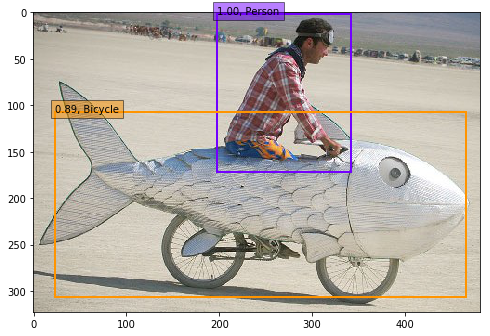

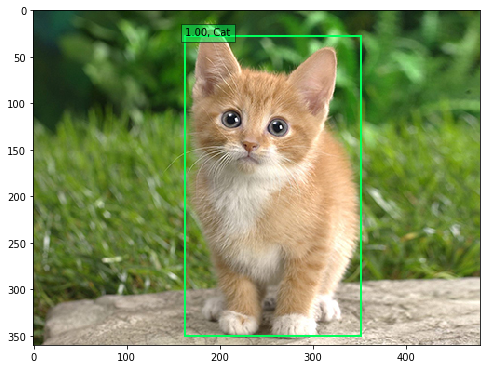

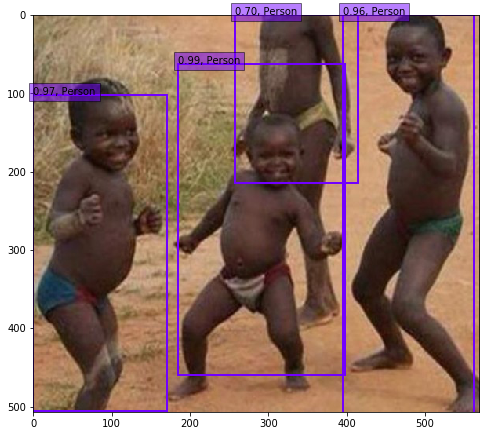

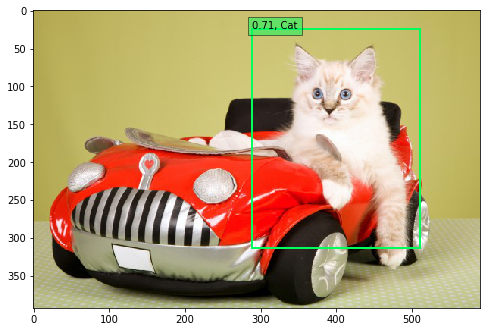

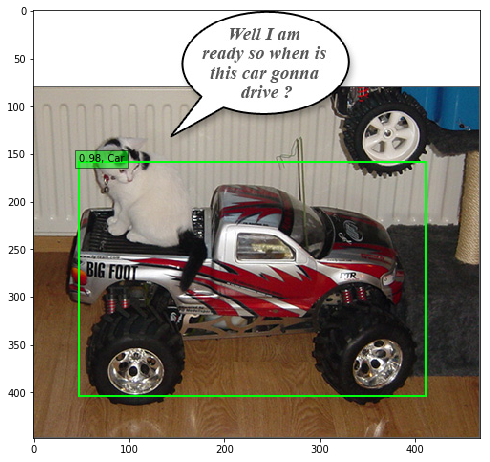

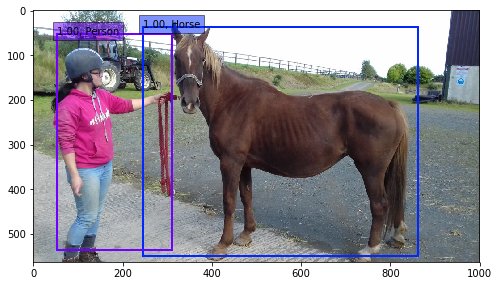

In [9]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

## 4. 学習させてみる

### データセットの取得

とりあえずVOC2007とかVOC2012とかのデータセットをダウンロードしてきます。

http://host.robots.ox.ac.uk/pascal/VOC/

<pre>
# wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
# wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

# tar xf VOCtrainval_11-May-2012.tar
# tar xf VOCtrainval_06-Nov-2007.tar
# tar xf VOCtest_06-Nov-2007.tar

# python get_data_from_XML.py
</pre>

<a href="./PASCAL_VOC/get_data.ipynb">PASCAL_VOC/get_data.ipynb</a> 参照。

### データセットの訓練

ssd_keras/SSD_training.ipynb　を実行する。

## 参考文献

SSD: Single Shot MultiBox Detector<br>
https://arxiv.org/abs/1512.02325

SSD: Single Shot MultiBox Detector；論文和訳<br>
https://qiita.com/de0ta/items/1ae60878c0e177fc7a3a

SSD: Single Shot MultiBox Detector 高速リアルタイム物体検出デモをKerasで試す<br>
https://qiita.com/PonDad/items/6f9e6d9397951cadc6be

物体検出アルゴリズム(SSD : Single Shot MultiBox Detector)を学習させてみる<br>
https://qiita.com/slowsingle/items/64cc927bb29a49a7af14